# Sprint 深層学習スクラッチ ディープニューラルネットワーク

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import copy

In [2]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """

    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0] / self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題1】全結合層のクラス化
全結合層のクラス化を行なってください。


以下に雛形を載せました。コンストラクタで重みやバイアスの初期化をして、あとはフォワードとバックワードのメソッドを用意します。重みW、バイアスB、およびフォワード時の入力Xをインスタンス変数として保持しておくことで、煩雑な入出力は不要になります。


なお、インスタンスも引数として渡すことができます。そのため、初期化方法のインスタンスinitializerをコンストラクタで受け取れば、それにより初期化が行われます。渡すインスタンスを変えれば、初期化方法が変えられます。


また、引数として自身のインスタンスselfを渡すこともできます。これを利用してself.optimizer.update(self)という風に層の重みの更新が可能です。更新に必要な値は複数ありますが、全て全結合層が持つインスタンス変数にすることができます。


初期化方法と最適化手法のクラスについては後述します。

In [3]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.initializer = initializer
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = self.initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = self.initializer.B(self.n_nodes2)
        self.dW = 0
        self.dB = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.X = X
        A = np.dot(X, self.W) + self.B   # (batch_size, n_nodes2)

        return A
    
    def backward(self, dA):   # TODO：Zを引数に渡さないやり方を考える
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # TODO　dw とdbをバッチサイズで割る　FCで実行
        self.dB = np.sum(dA, axis=0)
        self.dW = np.dot(self.X.T, dA)
        dZ = np.dot(dA, self.W.T)    # (batch_size, n_nodes1)
        
        # 更新
        self = self.optimizer.update(self)
        return dZ

## 【問題2】初期化方法のクラス化
初期化を行うコードをクラス化してください。


前述のように、全結合層のコンストラクタに初期化方法のインスタンスを渡せるようにします。以下の雛形に必要なコードを書き加えていってください。標準偏差の値（sigma）はコンストラクタで受け取るようにすることで、全結合層のクラス内にこの値（sigma）を渡さなくてすむようになります。


これまで扱ってきた初期化方法はSimpleInitializerクラスと名付けることにします。

In [4]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.random.randn(n_nodes2)
        
        return B

## 【問題3】最適化手法のクラス化
最適化手法のクラス化を行なってください。


最適化手法に関しても初期化方法同様に全結合層にインスタンスとして渡します。バックワードのときにself.optimizer.update(self)のように更新できるようにします。以下の雛形に必要なコードを書き加えていってください。


これまで扱ってきた最適化手法はSGDクラス（Stochastic Gradient Descent、確率的勾配降下法）として作成します。

In [5]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        # TODO Eの計算
        
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB

## 【問題4】活性化関数のクラス化
活性化関数のクラス化を行なってください。


ソフトマックス関数のバックプロパゲーションには交差エントロピー誤差の計算も含む実装を行うことで計算が簡略化されます。

In [6]:
class Tanh():
    def __init__(self):
        pass
        
    def forward(self, A):
        self.A = A
        return np.tanh(A)
    
    def backward(self, dZ):
        """
        dZ : n層目のバックプロバゲーション
        A :　n層目のフォワードプロバゲーションのA
        
        """
        y = dZ*((1-self.forward(self.A)**2))
        return y

In [7]:
class Sigmoid():
    def __init__(self):
        pass
        
    def forward(self, A):
        self.A = A
        return 1 / (1 + np.exp(-A))
    
    def backward(self, dZ):
        """
        dZ : n層目のバックプロバゲーション
        A :　n層目のフォワードプロバゲーションのA
         
        """
        y = dZ*(1-self.forward(self.A))*(self.forward(self.A))
        return y    

In [8]:
class Softmax():
    """
    ソフトマックス関数クラス
    """
    
    def __init__(self):
        pass
        
    def forward(self, A):
        # ソフトマックス計算 Zが出力値
        self.A = A
        c = np.max(A)
        self.Z = np.exp(A-c) / np.sum(np.exp(A-c), axis=1, keepdims=True)
        
        return self.Z
    
    def backward(self, Z, y):
        """
        dZ　: 最終層のZ
        Y　:　（バッチ）サンプルラベル
        """
        dZ = self.Z - y
        
        # クロスエントロピー誤差計算
        batch_size = y.shape[0]
        error = -np.sum(y*np.log(self.Z + 1e-7)) / batch_size
        
        return dZ , error
        

## 【問題5】ReLUクラスの作成
現在一般的に使われている活性化関数であるReLU（Rectified Linear Unit）をReLUクラスとして実装してください。


ReLUは以下の数式です。

$$
f(x)=ReLU(x)=
\begin{cases}
x \quad x \geqq 0 \\
0 \quad x < 0 \\
\end{cases}
$$

$x$ : ある特徴量。スカラー


実装上はnp.maximumを使い配列に対してまとめて計算が可能です。


numpy.maximum — NumPy v1.15 Manual


一方、バックプロパゲーションのための $x$ に関する $f(x)$ の微分は以下のようになります。

$$
\frac{∂f(x)}{∂x}=
        \begin{cases}
        1 \quad x \geqq 0 \\
        0 \quad x ≦ 0 \\
        \end{cases}
$$
数学的には微分可能ではないですが、 $x=0$ のとき $0$ とすることで対応しています。


フォワード時の $x$ の正負により、勾配を逆伝播するかどうかが決まるということになります。

In [164]:
# ゼロつくに乗っていたコード
class Relu():
    """
    Relu関数クラス
    """
    
    def __init__(self):
        self.mask = None
        
    def forward(self, A):
        self.mask = (A <= 0)
        out = A.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dz):
        """
        Z:
        y:
        
        """
        dz[self.mask] = 0
        y = dz
        
        return y

In [150]:
# Relu関数テスト
x = np.arange(-5, 5).reshape(5, 2)

relu = Relu()

print(relu.forward(x))
print(relu.backward(x))

[[0 0]
 [0 0]
 [0 0]
 [1 2]
 [3 4]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


## 【問題6】重みの初期値
ここまでは重みやバイアスの初期値は単純にガウス分布で、標準偏差をハイパーパラメータとして扱ってきました。しかし、どのような値にすると良いかが知られています。シグモイド関数やハイパボリックタンジェント関数のときは Xavierの初期値 （またはGlorotの初期値）、ReLUのときは Heの初期値 が使われます。


XavierInitializerクラスと、HeInitializerクラスを作成してください。

In [84]:
class XavierInitializer:
    """
    Xavierの初期値作成クラス
    
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        sigma = 1.0 / np.sqrt(n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.zeros(n_nodes2)
        
        return B

In [85]:
# XavierInitializerテスト
xavier = XavierInitializer()

print(xavier.W(400, 200)[:5])
print(xavier.B(200)[:5])

[[ 3.96272925e-02 -7.25457924e-03 -6.43566436e-02 -2.43820894e-02
   1.44638969e-02 -1.08927026e-02 -7.09560110e-02 -1.40981085e-01
  -5.72030007e-02  7.37842821e-02 -6.61378340e-02  8.04202272e-02
   5.91680496e-02  3.35842624e-02 -5.43736582e-02  2.80245068e-02
   8.49027551e-03  3.39315206e-02  7.59273259e-02 -3.51376168e-02
   2.22471587e-02 -6.90453782e-02  1.74384673e-02 -1.34272578e-02
  -9.26235320e-02 -7.02170290e-02  1.89832260e-02 -2.32902348e-02
   2.52798686e-02  4.46500675e-02 -1.95489644e-02  3.36459040e-02
   8.58390121e-02 -3.28112312e-02 -8.32458726e-02 -7.42986386e-03
  -6.33928789e-02  4.03879704e-02  2.12108059e-02 -1.51180597e-02
   1.20521848e-01 -5.90064276e-03 -1.53881126e-02  5.40379970e-02
   3.07673103e-02 -6.93753083e-02  2.44004790e-02 -4.40025149e-03
  -4.16833792e-02  6.09292152e-02 -2.23067350e-02 -6.81977636e-02
  -4.76240576e-02 -2.23145996e-02 -9.92977309e-03 -2.67828687e-02
  -9.21322827e-03 -1.46930959e-02 -1.06973831e-02  6.92195203e-03
   2.51000

In [141]:
class HeInitializer:
    """
    Heの初期値作成クラス
    
    """
    def __init__(self):
        pass
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        sigma = np.sqrt(2.0 / n_nodes1)
        W = sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = np.random.randn(n_nodes2)
        
        return B

In [87]:
# HeInitializerテスト
he = HeInitializer()

print(he.W(400, 200)[:5])
print(he.B(200)[:5])

[[ 6.44407202e-02 -2.09987811e-01  2.53719886e-03  1.11705389e-01
  -8.02657210e-02 -4.85724627e-02  1.00576777e-01 -9.94327980e-02
  -7.78442289e-02 -1.46477426e-01  8.33067080e-02  1.21938376e-01
   1.07690380e-01 -1.16511810e-02 -4.70955111e-02 -6.49023155e-02
   5.43041647e-02  1.27066969e-01  3.47596505e-02 -1.31039239e-01
   9.52227265e-03 -8.69881569e-02 -2.18215732e-02 -2.71616313e-02
   5.56186873e-02 -1.45049294e-02  1.34027603e-02 -3.66905455e-02
  -1.55387974e-02  9.04431789e-02 -7.94809334e-03  1.24354565e-01
   1.05997102e-02  1.44329831e-01 -6.01265347e-02 -1.86129463e-02
  -2.33782556e-02 -8.56290931e-02 -1.18839549e-01  1.82223813e-02
  -4.76353210e-02 -5.54349232e-02  4.11777410e-02 -5.20871321e-02
   9.32194637e-03  1.78532669e-01 -3.58325592e-02 -3.18926489e-02
   3.00621575e-02  1.06845131e-01  8.51621363e-04 -7.09943178e-03
   1.06530372e-01 -2.41360728e-02 -6.93668069e-02 -6.74591128e-03
   3.56260554e-02 -5.92913119e-02  7.92721604e-02 -6.33676968e-02
  -7.46849

## 【問題7】最適化手法
学習率は学習過程で変化させていく方法が一般的です。基本的な手法である AdaGrad のクラスを作成してください。


まず、これまで使ってきたSGDを確認します。

In [111]:
class Adagrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        self.HW = 0
        self.HB = 0
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.HW += np.square(layer.dW), axis=0
        layer.W -= self.lr * layer.dW / (np.sqrt(self.HW) + 1e-7)
        
        self.HB += np.square(layer.dB)
        layer.B -= self.lr * layer.dB / (np.sqrt(self.HB) + 1e-7)
        

## 【問題8】クラスの完成
任意の構成で学習と推定が行えるScratchDeepNeuralNetrowkClassifierクラスを完成させてください。

In [15]:
# データセットの読み込みから前処理まで
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

Using TensorFlow backend.


In [21]:
# SGD, SimpleInitializer, Tanh 
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, lr, n_nodes1, n_nodes2, n_output, sigma=0.01):
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        
    
    
    def fit(self, X, y, X_val=None, y_val=None, epoch=20):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, self.n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, self.n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.n_features = X.shape[1]
        self.loss = np.zeros(epoch)
        
        # 各インスタンス初期化
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(self.sigma), optimizer)
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(self.sigma), optimizer)
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(self.sigma), optimizer)
        self.activation3 = Softmax()
              
        # ラベル化
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size=20)
            
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロバゲーション
                A1 = self.FC1.forward(mini_X_train)     #shape(n_batch, n_nodes1)
                Z1 = self.activation1.forward(A1)     #shape(n_batch, n_nodes1)
                A2 = self.FC2.forward(Z1)        #shape(n_batch, n_nodes2
                Z2 = self.activation2.forward(A2)       #shape(n_batch, n_nodes2)
                A3 = self.FC3.forward(Z2)       #shape(n_batch, n_output)
                Z3 = self.activation3.forward(A3)     #shape(n_batch , n_output)
                
                # バックプロバゲーション
                dA3, self.loss[i] = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)     
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない        
        
        
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y = self.activation3.forward(A3)
        
        pred = np.argmax(y, axis=1)
        
        return pred

In [172]:
# SGD、Tanhで実行
scr_DNN = ScratchDeepNeuralNetrowkClassifier(lr=0.01, n_nodes1=400, n_nodes2=200, n_output=10)

scr_DNN.fit(X_train, y_train, epoch=20)
pred = scr_DNN.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [28]:
accuracy_score(y_test, pred)

0.9732

In [131]:
# Adagrad、SimpleInitializer, Tanhで実行

class ScratchDeepNeuralNetrowkClassifier2:
    def __init__(self, lr, n_nodes1, n_nodes2, n_output, sigma=0.01):
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
    
    
    def fit(self, X, y, X_val=None, y_val=None, epoch=20):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, self.n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, self.n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.n_features = X.shape[1]
        self.loss = np.zeros(epoch)
        
        # 各インスタンス初期化
        optimizer = Adagrad(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(sigma=0.01), copy.deepcopy(optimizer))
        self.activation1 = Tanh()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(sigma=0.01), copy.deepcopy(optimizer))
        self.activation2 = Tanh()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(sigma=0.01), copy.deepcopy(optimizer))
        self.activation3 = Softmax()
              
        # ラベル化
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size=20)
            
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロバゲーション
                A1 = self.FC1.forward(mini_X_train)     #shape(n_batch, n_nodes1)
                Z1 = self.activation1.forward(A1)     #shape(n_batch, n_nodes1)
                A2 = self.FC2.forward(Z1)        #shape(n_batch, n_nodes2
                Z2 = self.activation2.forward(A2)       #shape(n_batch, n_nodes2)
                A3 = self.FC3.forward(Z2)       #shape(n_batch, n_output)
                Z3 = self.activation3.forward(A3)     #shape(n_batch , n_output)
                
                # バックプロバゲーション
                dA3, self.loss[i] = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)     
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない        
        
        
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y = self.activation3.forward(A3)
        
        pred = np.argmax(y, axis=1)
        
        return pred

In [167]:
scr_DNN2 = ScratchDeepNeuralNetrowkClassifier2(lr=0.01, n_nodes1=400, n_nodes2=200, n_output=10)

scr_DNN2.fit(X_train, y_train, epoch=20)

pred2 = scr_DNN2.predict(X_test)
print("Accuracy:{}".format(accuracy_score(y_test, pred2)))

Accuracy:0.9768


In [168]:
# SGD、XavierInitializer, sigmoidで実行

class ScratchDeepNeuralNetrowkClassifier3:
    def __init__(self, lr, n_nodes1, n_nodes2, n_output, sigma=0.01):
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
    
    
    def fit(self, X, y, X_val=None, y_val=None, epoch=20):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, self.n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, self.n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.n_features = X.shape[1]
        self.loss = np.zeros(epoch)
        
        # 各インスタンス初期化
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, XavierInitializer(), copy.deepcopy(optimizer))
        self.activation1 = Sigmoid()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, XavierInitializer(), copy.deepcopy(optimizer))
        self.activation2 = Sigmoid()
        self.FC3 = FC(self.n_nodes2, self.n_output, XavierInitializer(), copy.deepcopy(optimizer))
        self.activation3 = Softmax()
              
        # ラベル化
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size=20)
            
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロバゲーション
                A1 = self.FC1.forward(mini_X_train)     #shape(n_batch, n_nodes1)
                Z1 = self.activation1.forward(A1)     #shape(n_batch, n_nodes1)
                A2 = self.FC2.forward(Z1)        #shape(n_batch, n_nodes2
                Z2 = self.activation2.forward(A2)       #shape(n_batch, n_nodes2)
                A3 = self.FC3.forward(Z2)       #shape(n_batch, n_output)
                Z3 = self.activation3.forward(A3)     #shape(n_batch , n_output)
                
                # バックプロバゲーション
                dA3, self.loss[i] = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)     
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない        
        
        
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y = self.activation3.forward(A3)
        
        pred = np.argmax(y, axis=1)
        
        return pred

In [169]:
scr_DNN3 = ScratchDeepNeuralNetrowkClassifier3(lr=0.01, n_nodes1=400, n_nodes2=200, n_output=10)

scr_DNN3.fit(X_train, y_train, epoch=20)

pred3 = scr_DNN3.predict(X_test)

print("Accuracy:{}".format(accuracy_score(y_test, pred3)))

Accuracy:0.9774


In [165]:
# SGD、Heinitializer, Reluで実行

class ScratchDeepNeuralNetrowkClassifier4:
    def __init__(self, lr, n_nodes1, n_nodes2, n_output, sigma=0.01):
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
    
    
    def fit(self, X, y, X_val=None, y_val=None, epoch=20):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, self.n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, self.n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.n_features = X.shape[1]
        self.loss = np.zeros(epoch)
        
        # 各インスタンス初期化
        optimizer = SGD(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, HeInitializer(), copy.deepcopy(optimizer))
        self.activation1 = Relu()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, HeInitializer(), copy.deepcopy(optimizer))
        self.activation2 = Relu()
        self.FC3 = FC(self.n_nodes2, self.n_output, HeInitializer(), copy.deepcopy(optimizer))
        self.activation3 = Softmax()
              
        # ラベル化
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size=20)
            
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロバゲーション
                A1 = self.FC1.forward(mini_X_train)     #shape(n_batch, n_nodes1)
                Z1 = self.activation1.forward(A1)     #shape(n_batch, n_nodes1)
                A2 = self.FC2.forward(Z1)        #shape(n_batch, n_nodes2
                Z2 = self.activation2.forward(A2)       #shape(n_batch, n_nodes2)
                A3 = self.FC3.forward(Z2)       #shape(n_batch, n_output)
                Z3 = self.activation3.forward(A3)     #shape(n_batch , n_output)
                
                # バックプロバゲーション
                dA3, self.loss[i] = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)     
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない        
        
        
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y = self.activation3.forward(A3)
        
        pred = np.argmax(y, axis=1)
        
        return pred

In [170]:
scr_DNN4 = ScratchDeepNeuralNetrowkClassifier4(lr=0.01, n_nodes1=400, n_nodes2=200, n_output=10)

scr_DNN4.fit(X_train, y_train, epoch=20)

pred4 = scr_DNN4.predict(X_test)
print("Accuracy:{}".format(accuracy_score(y_test, pred4)))

Accuracy:0.9807


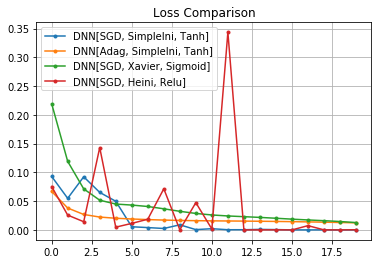

In [176]:
plt.title("Loss Comparison")
plt.plot(scr_DNN.loss, label="DNN[SGD, SimpleIni, Tanh]", marker=".")
plt.plot(scr_DNN2.loss, label="DNN[Adag, SimpleIni, Tanh]", marker=".")
plt.plot(scr_DNN3.loss, label="DNN[SGD, Xavier, Sigmoid]", marker=".")
plt.plot(scr_DNN4.loss, label="DNN[SGD, Heini, Relu]", marker=".")

plt.legend()
plt.grid()
plt.show()

## 比較・考察
- Relu関数が面白い波形になった。バックプロバゲーションの際に、0or1にするという極端な変化を加えるためと考えられる。

## 自習
- sklearnモデル[sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)を利用してみる
- パラメータが非常に多い。

In [177]:
from sklearn.neural_network import MLPClassifier

In [182]:
clf = MLPClassifier(random_state=1, max_iter=300, early_stopping=True)

clf.fit(X_train, y_train)

pred5 = clf.predict(X_test)
print("Accuracy:{}".format(accuracy_score(y_test, pred5)))

Accuracy:0.9737


### スクラッチモデルをsklearnと同じようにインスタンス時のパラメータでinitilizerやoptimizerを選べるようにしてみる

In [189]:
# SGD、Heinitializer, Reluで実行

class ScratchDeepNeuralNetrowkClassifier5:
    def __init__(self, lr, n_nodes1, n_nodes2, n_output, sigma=0.01, Initializer="Simple", optimizer="SGD", activation="relu"):
        self.lr = lr
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.sigma = sigma
        
        self.Initializer = {"Simple":SimpleInitializer(sigma=0.01), "Xavier": XavierInitializer(), "He": HeInitializer()}
        self.optimizer = {"SGD": SGD, "Adagrad": Adagrad}
        self.activation = {"sigmoid": Sigmoid, "tanh": Tanh, "relu": Relu}
        
    def fit(self, X, y, X_val=None, y_val=None, epoch=20):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, self.n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, self.n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.n_features = X.shape[1]
        self.loss = np.zeros(epoch)
        
        # 各インスタンス初期化
        optimizer = self.optimizer.values(self.lr)
        self.FC1 = FC(self.n_features, self.n_nodes1, copy.deepcopy(self.Initializer), copy.deepcopy(optimizer))
        self.activation1 = copy.deepcopy(self.activation())
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, copy.deepcopy(self.Initializer), copy.deepcopy(optimizer))
        self.activation2 = copy.deepcopy(self.activation())
        self.FC3 = FC(self.n_nodes2, self.n_output, copy.deepcopy(self.Initializer), copy.deepcopy(optimizer))
        self.activation3 = Softmax()
              
        # ラベル化
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y[:, np.newaxis])
        
        for i in range(epoch):
            get_mini_batch = GetMiniBatch(X, y_train_one_hot, batch_size=20)
            
            for mini_X_train, mini_y_train in get_mini_batch:
                # フォワードプロバゲーション
                A1 = self.FC1.forward(mini_X_train)     #shape(n_batch, n_nodes1)
                Z1 = self.activation1.forward(A1)     #shape(n_batch, n_nodes1)
                A2 = self.FC2.forward(Z1)        #shape(n_batch, n_nodes2
                Z2 = self.activation2.forward(A2)       #shape(n_batch, n_nodes2)
                A3 = self.FC3.forward(Z2)       #shape(n_batch, n_output)
                Z3 = self.activation3.forward(A3)     #shape(n_batch , n_output)
                
                # バックプロバゲーション
                dA3, self.loss[i] = self.activation3.backward(Z3, mini_y_train) # 交差エントロピー誤差とソフトマックスを合わせている
                dZ2 = self.FC3.backward(dA3)     
                dA2 = self.activation2.backward(dZ2)
                dZ1 = self.FC2.backward(dA2)
                dA1 = self.activation1.backward(dZ1)
                dZ0 = self.FC1.backward(dA1) # dZ0は使用しない        
        
        
    def predict(self,X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        y = self.activation3.forward(A3)
        
        pred = np.argmax(y, axis=1)
        
        return pred

### 上記は個人的宿題